This is a publicly available dataset for COVID 19 vaccinations and disease spread. COVID has impacted each one of us very closely, with us being datascientists we can look at the impact of covid at a country and global level and use that to help prepare for a better future

In [1]:
# imports 
import math
import numpy as np 
import pandas as pd 
import plotly.express as ex
import plotly.graph_objects as go
import plotly.offline as pyo
from datetime import datetime
pyo.init_notebook_mode()

In [2]:
# load data
vacc_df = pd.read_csv("/kaggle/input/covid-world-vaccination-progress/country_vaccinations.csv")
summary_df = pd.read_csv("/kaggle/input/covid19-global-dataset/worldometer_coronavirus_summary_data.csv")
daily_df = pd.read_csv("/kaggle/input/covid19-global-dataset/worldometer_coronavirus_daily_data.csv")

# Data Cleaning

The most important step to take before we get started geenrating any kind of information from all these data sources, it is first important to clean our data and make sure that the datasets are compatible with each other. Since most of the data is divided on a country-by-country basis, we must make sure that all the country names have the same formatting. 

For instance, "United States of America" may be written as "USA", "United Kingdom" as "UK" and so on. We will explore this problem and others in this section. We will prioritize only those countries for which vaccination data is available since most countries have either not yet started vaccinations or do not yet have sufficiently available public data.

## Standardize Country Names

### Steps followed:
- Identify the differences 
- Plan on how to unify them 
- Implement in code 

In [3]:
# Identify the differences
print("Countries in the Vaccination Data not in Summary Data")
print([x for x in vacc_df.country.unique() if x not in summary_df.country.unique()])

Countries in the Vaccination Data not in Summary Data
['Antigua and Barbuda', 'Bonaire Sint Eustatius and Saba', 'Bosnia and Herzegovina', 'Brunei', 'Cape Verde', "Cote d'Ivoire", 'Czechia', 'Democratic Republic of Congo', 'England', 'Eswatini', 'Falkland Islands', 'Guernsey', 'Guinea-Bissau', 'Hong Kong', 'Isle of Man', 'Jersey', 'Kosovo', 'Macao', 'North Macedonia', 'Northern Cyprus', 'Northern Ireland', 'Palestine', 'Pitcairn', 'Saint Kitts and Nevis', 'Saint Vincent and the Grenadines', 'Sao Tome and Principe', 'Scotland', 'Sint Maarten (Dutch part)', 'Timor', 'Tokelau', 'Trinidad and Tobago', 'Turkmenistan', 'Turks and Caicos Islands', 'Tuvalu', 'United Kingdom', 'United States', 'Vietnam', 'Wales', 'Wallis and Futuna']


Let us see if we can find their equivalent in the Summary Dataset 

In [4]:
print(summary_df.country.unique().tolist())

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Anguilla', 'Antigua And Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia And Herzegovina', 'Botswana', 'Brazil', 'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Caribbean Netherlands', 'Cayman Islands', 'Central African Republic', 'Chad', 'Channel Islands', 'Chile', 'China Hong Kong Sar', 'China Macao Sar', 'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands', 'Costa Rica', 'Cote D Ivoire', 'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czech Republic', 'Democratic Republic Of The Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Faeroe Islands', 'Falkland Islands Malvinas', 'Fiji',

From the above list, using `Ctrl+F` to search, we quickly find some equivalents as :

**Replace**
- 'Czechia' == "Czech Republic"
- 'Isle of Man' == "Isle Of Man" 
- 'United Kingdom' == "UK"
- 'United States' == "USA"
- 'Northern Cyprus' == "Cyprus"

**Drop** 
- England 
- Wales 
- Scotland 
- Northern Ireland

(since they are a part of the UK) 

#No other big issues found

In [5]:
# Implement the above
vacc_df.country = vacc_df.country.replace().replace({
    "Czechia": "Czech Republic", 
    "United States": "USA", 
    "United Kingdom": "UK", 
    "Isle of Man": "Isle Of Man",
    "Republic of Ireland": "Ireland",
    "Northern Cyprus" : "Cyprus"
})

# drop these 3 since they are included in UK 
vacc_df = vacc_df[vacc_df.country.apply(lambda x: x not in ['England', 'Scotland', 'Wales', 'Northern Ireland'])]

In [6]:

# function to easily agrregate columns
def aggregate(df: pd.Series, agg_col: str) -> pd.DataFrame:
    
    data = df.groupby("country")[agg_col].max()
    data = pd.DataFrame(data)
    
    return data

## Extend the Summary Data

The summary dataset already contains a lot of aggregate data about the virus itself but no information surrounding the vaccinations. So we will use the Vaccination dataset to add this information as new columns. This will make it significantly more convenient to process and visualize later on.

New Information:

- Number of vaccine doses administered
- Total number of unique people vaccinated 
- Total number of people fully vaccinated
- Number of vaccine doses administered per hundred
- Total number of unique people vaccinated per hundred
- Total number of people fully vaccinated per hundred 
- Vaccine combinations in use for each country
- Percentage of the total population vaccinated
- Percentage of the tested that returned positive


The numeric columns in the Vaccination dataset other than the ones marked "daily" are cumulative data. Hence the latest value will be the maximum among the column. For this reason, we will using the `groupby.max()` function as it works well with `NaN` values.

In [7]:
# Join vaccines information to the summary DataFrame
# define the columns we want to summarize
cols_to_summarize = ['people_vaccinated', 
                     'people_vaccinated_per_hundred', 
                     'people_fully_vaccinated', 
                     'people_fully_vaccinated_per_hundred', 
                     'total_vaccinations_per_hundred', 
                     'total_vaccinations']

summary = summary_df.set_index("country")
vaccines = vacc_df[['country', 'vaccines']].drop_duplicates().set_index('country')
summary = summary.join(vaccines)

for col in cols_to_summarize:   
    summary = summary.join(aggregate(vacc_df, col))

summary['percentage_vaccinated'] = summary.total_vaccinations / summary.population * 100
summary['tested_positive'] = summary.total_confirmed / summary.total_tests * 100



In [8]:
# Data used for this section
summary.head(5)

continent  total_confirmed  total_deaths  total_recovered  \
country                                                                 
Afghanistan      Asia           179267        7690.0         162202.0   
Albania        Europe           275574        3497.0         271826.0   
Algeria        Africa           265816        6875.0         178371.0   
Andorra        Europe            42156         153.0          41021.0   
Angola         Africa            99194        1900.0          97149.0   

             active_cases  serious_or_critical  total_cases_per_1m_population  \
country                                                                         
Afghanistan        9375.0               1124.0                           4420   
Albania             251.0                  2.0                          95954   
Algeria           80570.0                  6.0                           5865   
Andorra             982.0                 14.0                         543983   
Angola              145.0                  NaN                           2853   

             total_deaths_per_1m_population  total_tests  \
country                                                    
Afghanistan                           190.0     951337.0   
Albania                              1218.0    1817530.0   
Algeria                               152.0     230861.0   
Andorra                              1974.0     249838.0   
Angola                                 55.0    1499795.0   

             total_tests_per_1m_population  population  \
country                                                  
Afghanistan                        23455.0    40560636   
Albania                           632857.0     2871945   
Algeria                             5093.0    45325517   
Andorra                          3223924.0       77495   
Angola                             43136.0    34769277   

                                                      vaccines  \
country                                                          
Afghanistan  Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...   
Albania      Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac, ...   
Algeria      Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...   
Andorra           Moderna, Oxford/AstraZeneca, Pfizer/BioNTech   
Angola                                      Oxford/AstraZeneca   

             people_vaccinated  people_vaccinated_per_hundred  \
country                                                         
Afghanistan          5082824.0                          12.76   
Albania              1278902.0                          44.52   
Algeria              7461932.0                          16.72   
Andorra                57817.0                          74.74   
Angola              11235059.0                          33.11   

             people_fully_vaccinated  people_fully_vaccinated_per_hundred  \
country                                                                     
Afghanistan                4420127.0                                11.10   
Albania                    1215199.0                                42.30   
Algeria                    6110712.0                                13.70   
Andorra                      53367.0                                68.99   
Angola                     5993792.0                                17.66   

             total_vaccinations_per_hundred  total_vaccinations  \
country                                                           
Afghanistan                           14.44           5751015.0   
Albania                               95.87           2754244.0   
Algeria                               30.72          13704895.0   
Andorra                              196.50            151997.0   
Angola                                51.68          17535411.0   

             percentage_vaccinated  tested_positive  
country                                              
Afghanistan              14.178809        18.843691  
Albania      

**Note**: We notice that not all countries have all summary information available. So we need to be careful about how we handle `NaN` values

# Visualizations

This section is the crux of the project, where we take the cleaned and processed data and turn them into intuitive graphs. Note that since Medium does not support interactive graphing, I have uploaded screenshots from my Kaggle Notebook. To get the full Plotly Experience, you can check out the notebook linked in the introduction.

In [9]:
# helper functions 
def get_multi_line_title(title:str, subtitle:str):
    return f"{title}<br><sub>{subtitle}</sub>"
def visualize_column(data: pd.DataFrame, xcolumn: str, ycolumn: str, title: str, colors: str, ylabel: str = "Count", n: int = None):
    """
    Create a bar chart visualization with multi-line title.

    Args:
        data (pd.DataFrame): The data to visualize.
        xcolumn (str): Name of the x-axis column.
        ycolumn (str): Name of the y-axis column.
        title (str): Title of the visualization (can include <br> for line breaks).
        colors (str): Color scale for the bars.
        ylabel (str, optional): Label for the y-axis. Defaults to "Count".
        n (int, optional): Number of top items to display. Defaults to None.
    """

    # Prepare data
    data = data.sort_values(ycolumn, ascending=False).dropna(subset=[ycolumn])
    if n is not None:
        data = data.iloc[:n]
    else:
        n = ""

    # Create figure
    hovertemplate = '<br><b>%{x}</b>' + f'<br><b>{ylabel}: </b>' + '%{y}<br><extra></extra>'
    fig = go.Figure(go.Bar(
        hoverinfo='skip',
        x=data[xcolumn],
        y=data[ycolumn],
        hovertemplate=hovertemplate,
        marker=dict(
            color=data[ycolumn],
            colorscale=colors,
        ),
    ))

    # Configure layout with multi-line title
    fig.update_layout(
        title_text=title,  # Use title_text for HTML-formatted title
        xaxis_title=f"Top {n} {xcolumn.title()}",
        yaxis_title=ylabel,
        plot_bgcolor='rgba(0,0,0,0)',
        hovermode="x"
    )

    fig.show()

# Example usage
# visualize_column(data, 'x_column_name', 'y_column_name', 'Title<br>Subtitle', 'Viridis', n=10)

## Visualizing Summaries

Let’s kick things off by visualising the summaries we computed back in the Data Processing section. Since data is summaries by countries, the visualisations can get quite skewed when we sort the values. So for the sake of comprehension, we will only compare the top-20 countries in each section.


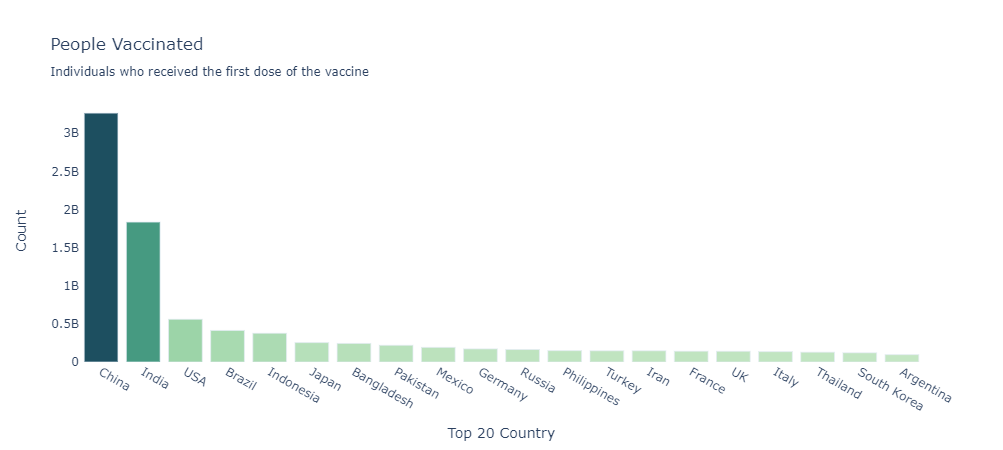

In [10]:
title = get_multi_line_title("People Vaccinated", "Individuals who received the first dose of the vaccine")
visualize_column(summary.reset_index(), 'country', "total_vaccinations", title, "Blugrn", n=20 )

#### Worst hit, but fastest recovering? 
We see that the China and India are leading in terms of the total number of vaccinations administered. Note that this is an indicator of people who have received at least the first dose since the vaccination process generally consists of multiple doses administered over time.

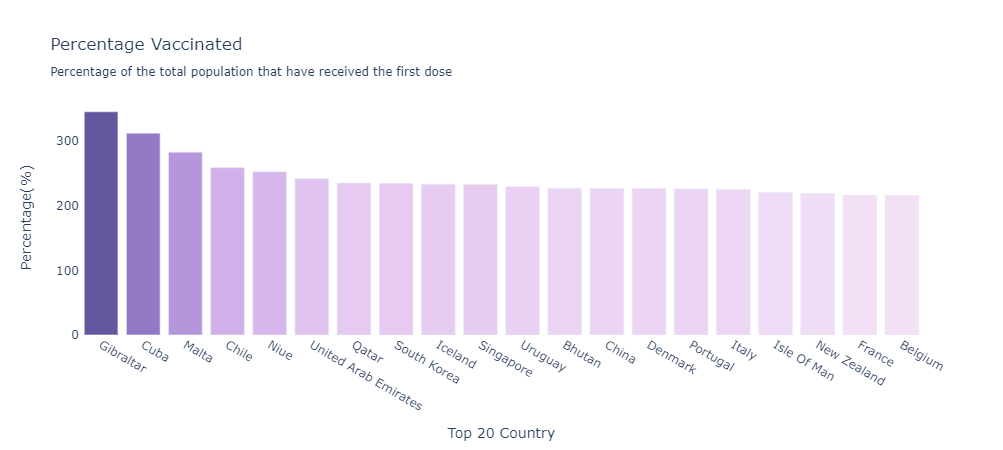

In [11]:
title = get_multi_line_title("Percentage Vaccinated", "Percentage of the total population that have received the first dose")
visualize_column(summary.reset_index(), 'country', "percentage_vaccinated", title, "Purp", "Percentage(%)", n=20)

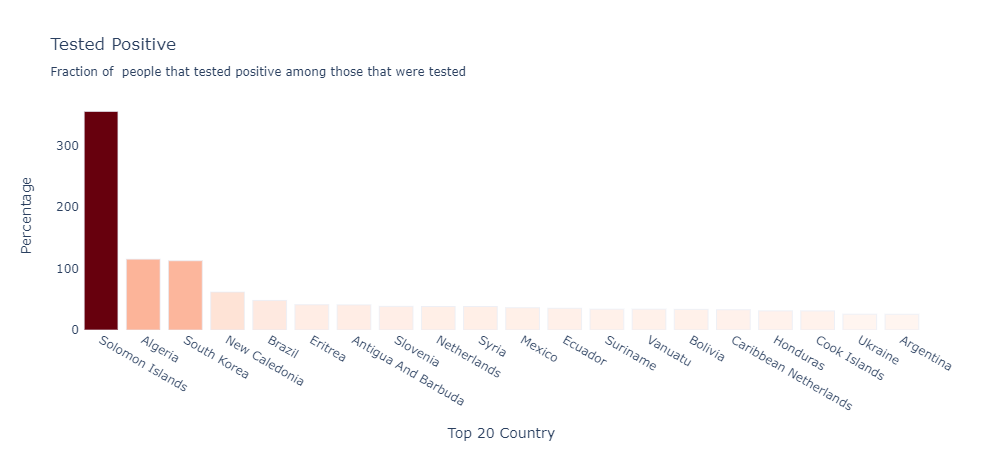

In [12]:
title = get_multi_line_title("Tested Positive ", "Fraction of  people that tested positive among those that were tested")
visualize_column(summary.reset_index(), 'country',"tested_positive", title, "Reds", n=20, ylabel='Percentage' )

#### What do we understand? 
At first glance, it might seem that Solomon Islands, Algeria, South Korea are suffering the worst since >100% of those tested for Covid-19 came back positive. It's possible that the infection rate is higher because of a newer variant, the data can be further segmented by year if needed

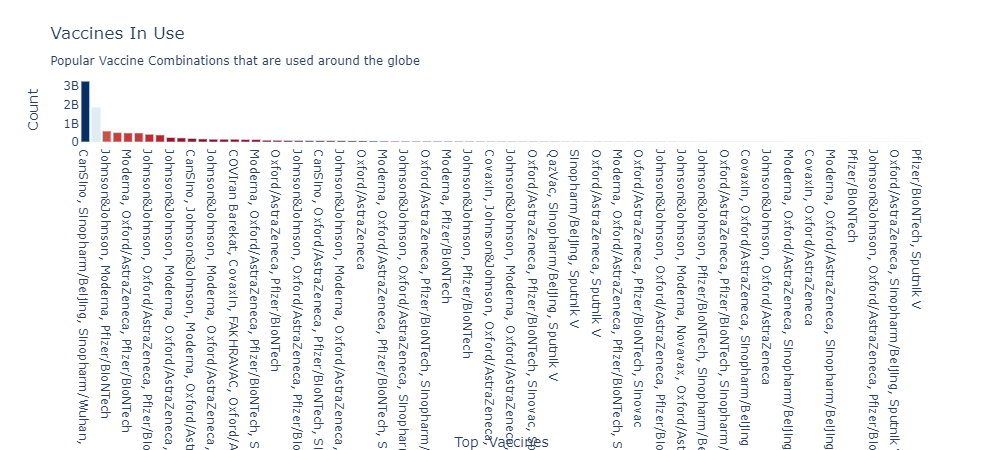

In [13]:
data = summary.dropna(subset=['vaccines'])
data = summary.groupby('vaccines')['total_vaccinations'].sum()
data = pd.DataFrame(data).reset_index()

title = get_multi_line_title("Vaccines In Use", "Popular Vaccine Combinations that are used around the globe")
visualize_column(data, 'vaccines',"total_vaccinations", title, "RdBu" )

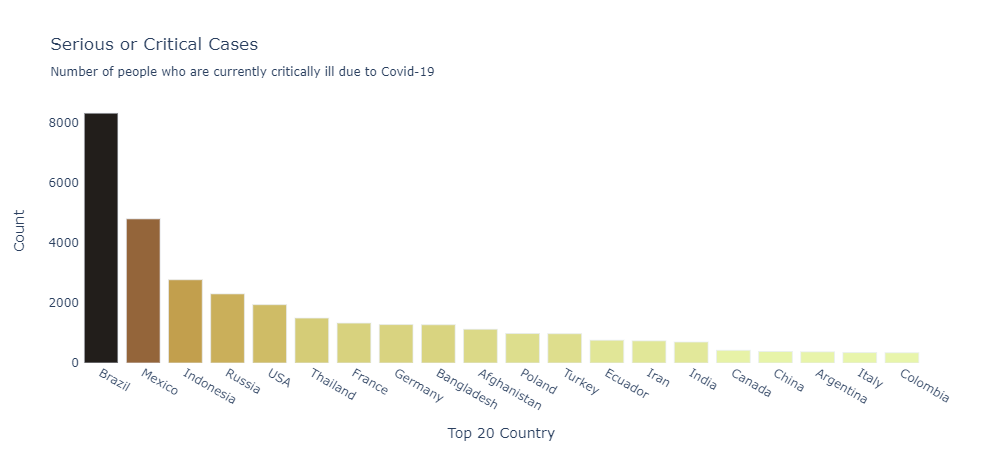

In [14]:
data = summary.dropna(subset=['serious_or_critical'])
data = data.reset_index()

title = get_multi_line_title("Serious or Critical Cases", "Number of people who are currently critically ill due to Covid-19")
visualize_column(data, 'country',"serious_or_critical", title, "turbid", n=20)


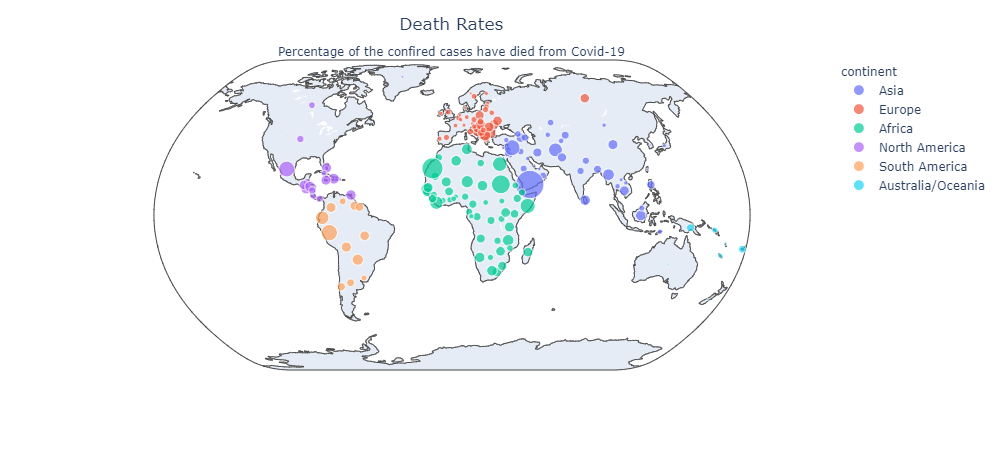

In [15]:
title = get_multi_line_title("Death Rates", "Percentage of the confired cases have died from Covid-19")
data = summary_df.copy()
data['death_rate'] =  data['total_deaths']*100/data['total_confirmed']
data = data.dropna(subset=['death_rate'])
fig = ex.scatter_geo(data, locations="country", color="continent",
                     locationmode='country names',
                     hover_name="country", size="death_rate",
                     projection="natural earth")
fig.update_layout(title=title, title_x=0.45)
fig.show()

#### A Quick Reminder!
Above, is perhaps the scariest graph in my analysis and the one that is the largest cause for concern. These are the numbers that we are fighting to reduce. As we have heard from multiple sources online, these numbers mainly represent the old and those with pre-existing medical conditions fighting for their lives against this terrible virus.

## Visualizing Active Cases, Cured and Deaths

Each country has been dealing with the pandemic differently, with some showing more timely response than others. There is not better way to quantify and compare how well a country has been handling the virus than by looking at the total number of confirmed cases and split it up in terms of:

- **Currently Active** : Patients who are currently diagnosed with Covid-19 and are undergoing treatment
- **Cured** : The number of people who contracted the virus ayt some point but were eventually cured 
- **Deaths** : Perhaps the most critical metric of all, the number of lives that have been lost due to the virus

To keep all measurements on the same scale, we divide the values by the total populations of the respective countries

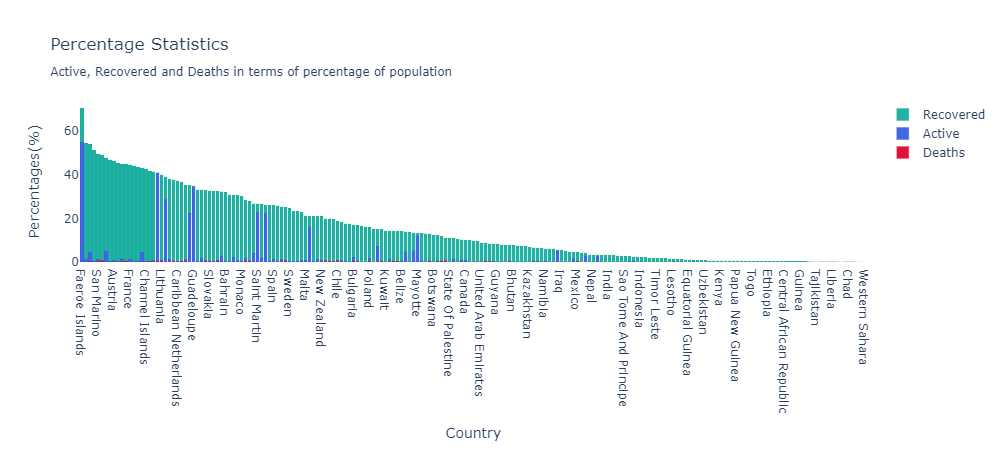

In [16]:
title = get_multi_line_title("Percentage Statistics", "Active, Recovered and Deaths in terms of percentage of population")

data = summary.reset_index().dropna(subset=['active_cases', 'total_recovered', 'total_deaths','population'])
data['active_percent'] = data['active_cases']/data['population'] * 100
data['recovered_percent'] = data['total_recovered']/data['population'] * 100
data['deaths_percent'] = data['total_deaths']/data['population'] * 100
data['confirmed_percent'] = data['total_confirmed']/data['population'] * 100
data = data.sort_values('confirmed_percent', ascending=False).drop_duplicates(subset=['country'])

fig = go.Figure(data=[
                go.Bar(
                    name="Deaths",
                    x=data['country'], 
                    y=data['deaths_percent'],
                    marker_color='crimson',
                    marker=dict(line=dict(
                                  width=0.1,
                                  color='red'
                                )
                            )
                ),
                go.Bar(
                    name="Active",
                    x=data['country'], 
                    y=data['active_percent'],
                    marker_color='royalblue',
                    marker=dict(
                              line=dict(
                                  width=0.1,
                                  color='blue'
                              )
                        )
                ),
                go.Bar(
                    name="Recovered",
                    x=data['country'], 
                    y=data['recovered_percent'],
                    marker_color='lightseagreen',
                    marker=dict(
                              line=dict(
                                  width=0.1,
                                  color='green'
                              )
                        )
                )

            ])

fig.update_layout(
        title=title,
        xaxis_title="Country",
        yaxis_title="Percentages(%)",
        plot_bgcolor='rgba(0,0,0,0)',
        hovermode="x",
        barmode='stack'
    )


Let us now look at the same data as above but from a slightly different persepctive. 

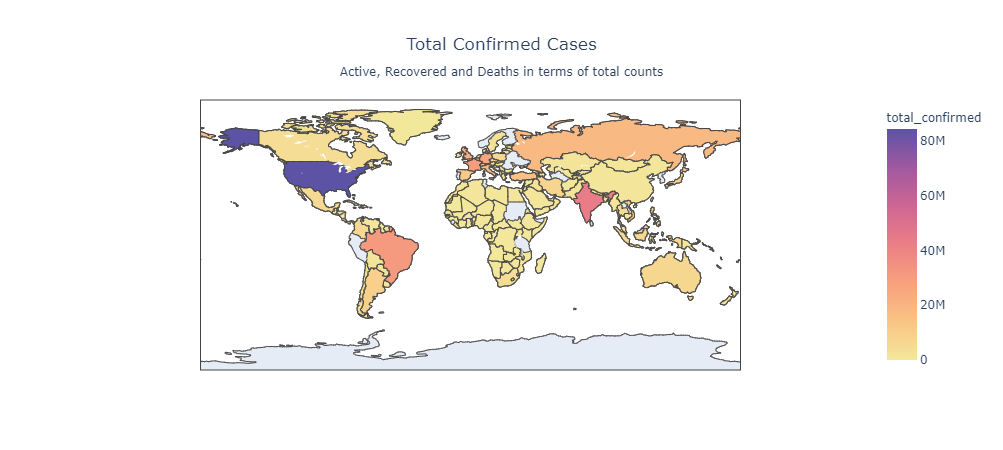

In [17]:
# choropleth maps for easier visualization
title = get_multi_line_title("Total Confirmed Cases", "Active, Recovered and Deaths in terms of total counts")

fig = ex.choropleth(data, locations="country", 
                    locationmode='country names',
                    color="total_confirmed", 
                    hover_name="country", 
                    hover_data=['total_deaths', 'active_cases', 'total_recovered'],
                    title='Global Vaccinations over time',
                    color_continuous_scale="Sunset"
                   )

fig.update_layout(title=title, 
#                   coloraxis_showscale=False, 
                  title_x=0.5)
fig.show()

## Vaccine Preference by Country

Different countries are using different vaccines to fight against covid-19. Let us try to visualize this using the data we prepared earlier.

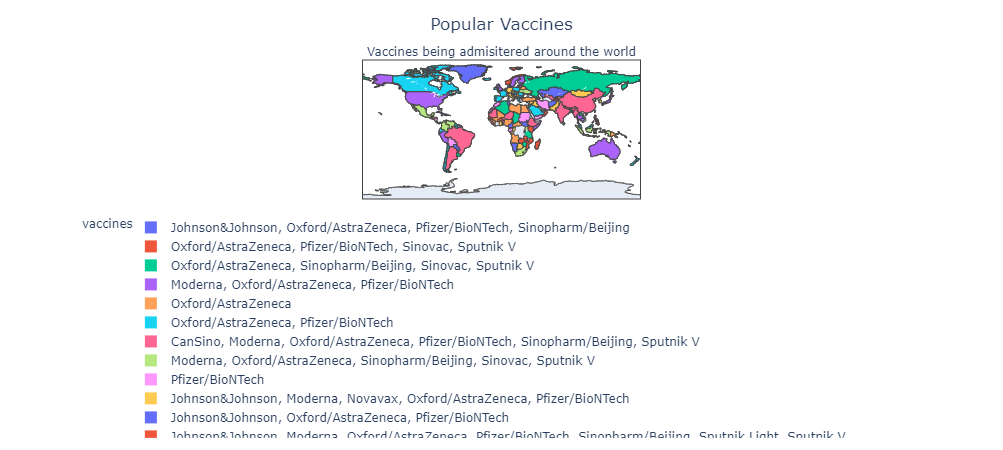

In [18]:
# plot popular vaccines around the world
title = get_multi_line_title("Popular Vaccines", "Vaccines being admisitered around the world")
data = summary.reset_index().dropna(subset=['vaccines'])
fig = ex.choropleth(data, locations="country", 
                    locationmode='country names',
                    color="vaccines", 
                    hover_name="country", 
                   )


fig.update_layout(title=title, 
                  title_x=0.5,
    legend_orientation = 'h'
)
fig.show()

## Confirmed Cases by Continent 

Let's take a look at the total cases by continent and see which ones have been hit the worst. 

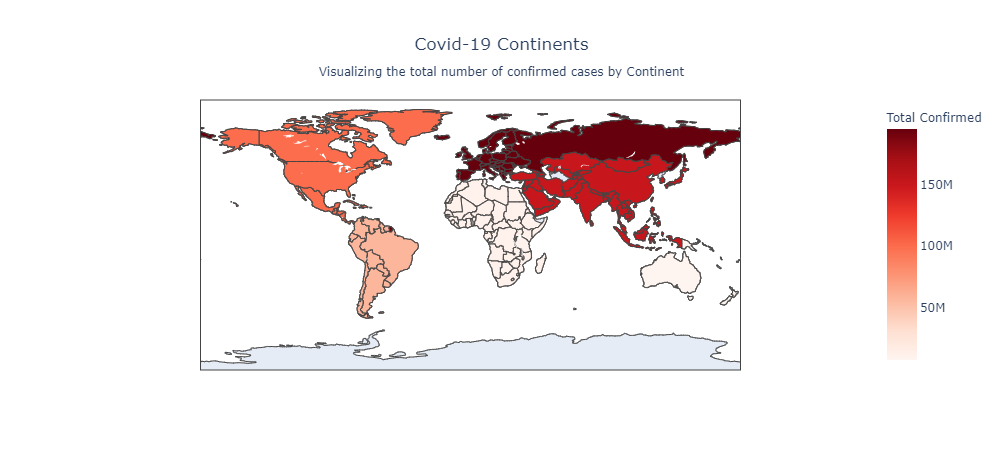

In [19]:
title = get_multi_line_title("Covid-19 Continents", "Visualizing the total number of confirmed cases by Continent")

continent_confirmed = summary_df.groupby(['continent'])['total_confirmed'].sum()
continent_active = summary_df.groupby(['continent'])['active_cases'].sum()
continent_deaths = summary_df.groupby(['continent'])['total_deaths'].sum()
continent_recovered = summary_df.groupby(['continent'])['total_recovered'].sum()

data = summary_df.copy()
data['Total Confirmed'] = data.continent.apply(lambda x: continent_confirmed[x])
data['Active Cases'] = data.continent.apply(lambda x: continent_active[x])
data['Total Deaths'] = data.continent.apply(lambda x: continent_deaths[x])
data['Total Recovered'] = data.continent.apply(lambda x: continent_recovered[x])


fig = ex.choropleth(data, locations="country", 
                    locationmode='country names',
                    color="Total Confirmed", 
                    hover_name="continent", 
                    hover_data=['Active Cases', 'Total Confirmed','Total Deaths', 'Total Recovered' ],
                    title=title,
                    color_continuous_scale="reds"
                   )


fig.update_layout(title=title, 
                  title_x=0.5)

fig.show();

## Vaccinations Over Time

Now we come to my favourite plot of this notebook: Visualizing how the vaccinations have been progressing around the world. The most exciting part is that for each passing day that I run this notebook, the graph keeps getting better an better, indidicating new countries that have started vaccinations, or how previously vaccinating countries have been accelerating their progress. 

However, We first need to clean our data a little further in order to generate this data: 

- For each country that has started vaccinations, **ensure that there is atleast 1 entry for each date** since the earliest date. This is because we want the change in color to be gradual for all countries. Otherwise, the countries will suddenly pop in with dark colors at the time of their first entry. 

- **Scale the values to a log scale**. This again, ensures a more pleasant shift in colors that is a lot more interpretable. Otheriwse, the gaps between the counts for countries will be too large to make any sense of

In [20]:
# unique dates 
dates = vacc_df.date.unique().tolist()
dates.extend(['2020-12-12', '2020-12-13']) #add 2 dates to improve animation 

# unique countries 
countries = vacc_df.country.unique().tolist()

# for easy processing 
short = vacc_df[['date', 'country', 'total_vaccinations']]

# values of unqiue (date, country) already in short 
# i.e we want to make sure we have some data for each, even if it is 0 
keys= list(zip(short.date.tolist(), short.country.tolist()))
for date in dates:
    for country in countries:
        idx = (date, country)
        if idx not in keys:
            if date == min(dates):
                # this means there's no entry for {country} on the earliest date 
                short = short.append({
                    "date": date, 
                    "country": country, 
                    "total_vaccinations": 0
                }, ignore_index=True)
            else:
                # entry for {country} is missing on a date other than the earliest
                short = short.append({
                    "date": date, 
                    "country": country, 
                    "total_vaccinations": pd.NA
                }, ignore_index=True)
                
#fill missing values with previous day values (this is OK since it is cumulative)
short = short.sort_values(['country', 'date'])

short.total_vaccinations = short.total_vaccinations.fillna(method='ffill')

# scale the number by log to make the color transitions smoother
vaccines = short.sort_values('date')
vaccines['log_scale'] = vaccines['total_vaccinations'].apply(lambda x : math.log2(x+1))

fig = ex.choropleth(vaccines, locations="country", 
                    locationmode='country names',
                    color="log_scale", 
                    hover_name="country", 
                    hover_data=['log_scale', "total_vaccinations"],
                    animation_frame="date",
                    color_continuous_scale="BuGn",
                   )

title = get_multi_line_title("Vaccination Progress", "Number of Vaccines Administered Around the World")
fig.update_layout(coloraxis={"cmax":25,"cmin":0})
fig.update_layout(title=title, title_x=0.5, coloraxis_showscale=False)

fig.show()

KeyboardInterrupt: 

## Rate of Vaccination

While the above animation helps us to get an overview of hour different countries have been doing with respect to each other, we will also visualize the top-10 countries by total vaccinations. This is quite easy to plot, since we will use the same data used for above plot

In [ ]:
# choose only top-10 
countries = short.groupby('country')['total_vaccinations'].max().sort_values(ascending=False)[:10].index.tolist()

title = get_multi_line_title("Vaccination Progress", "Rate of vaccinations for the top-10 vaccinated countries")

line_plots = []
for c in countries:
    vacc_data = short[short.country == c]
    line_plots.append(
        go.Scatter(
            name = c,
            x = vacc_data.date,
            mode='lines+markers',
            y=vacc_data['total_vaccinations'],
        )
    )
    
fig = go.Figure(line_plots)
fig.update_layout(
    title =title,
    yaxis_title="Count",
    hovermode='x',
    legend_orientation = 'h',

)


fig.show()

## The Race Against Covid!

We have to datasets that record daily statistics about Covid-19 and vaccinations respectively. We can put this data together to compare the spread of the virus against the "spread" of the vaccine! Ideally, we would want to see a downward trend in the new cases alongside an upward trend in the number of vaccinations administered globally. 

In order to do this, we have to first deal with the following problems: 

- We only have vaccination data starting from 13-12-2020 : So we will only consider the disease statistics from this date as well. 
- The dates in the the two datasets have different formats : So we will use the `datetime` library to standardize it 
- Only a few countries have started the vaccination. So we will consider only the new cases in these countries. 

In [ ]:
# copy the datasets
vaccs = vacc_df.copy()
daily = daily_df.copy()

# standardise the dates 
vaccs.date =vaccs.date.apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
daily.date =daily.date.apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

# use only common countries and dates 
countries = vaccs.dropna(subset=['daily_vaccinations'])['country'].unique()
dates = vaccs.dropna(subset=['daily_vaccinations'])['date'].unique()
country_mask = daily.country.apply(lambda x: x in countries)
date_mask = daily.date.apply(lambda x: x in dates)

# generate the visualization data 
columns_to_sum = ['daily_new_cases', 'cumulative_total_cases', 'cumulative_total_deaths', 'active_cases']
daily_cases = daily[country_mask & date_mask].groupby('date')[columns_to_sum].sum()
daily_vaccs = vaccs.groupby('date')[[ 'daily_vaccinations']].sum()

# make it a dataframe for convenience  
data = pd.DataFrame(daily_cases).join(pd.DataFrame(daily_vaccs))

# bring back the vaccine data we prepared in the previous section 
cumulative_vaccines = pd.DataFrame(vaccines.groupby('date')['total_vaccinations'].sum())
data = data.join(cumulative_vaccines).reset_index()

In [ ]:
# Data Format used for this section
data.head()

In [ ]:
title = get_multi_line_title("Vaccine vs Virus", "Comparing the total number of daily new cases and daily vaccinations globally")
fig = go.Figure(data=[
                go.Bar(
                    name="New Cases",
                    x=data['date'], 
                    y=data['daily_new_cases'],
                    marker_color="crimson",
                ),
                go.Bar(
                    name="Vaccinated",
                    x=data['date'], 
                    y=data['daily_vaccinations'],
                    marker_color="lightseagreen"
                ),

            ])

fig.update_layout(
        title=title,
        xaxis_title="Date",
        yaxis_title="Count",
        plot_bgcolor='rgba(0,0,0,0)',
        barmode='stack',
        hovermode="x"
    )

fig.show()

#### What do we understand from this? 
Very interesting! We clearly see that both the vaccinations and the new cases seem to follow a common "wave-like" trend. If we look carefully, we see that the peaks almost always fall on Thursdays! Maybe this is just in line with the way most people have their schedules planned out. 

The trend is already visible even from 2020 data, as the number of vaccines increase the number of people infected keeps going down 

In [ ]:
title = get_multi_line_title("The Race Against Covid", "Visualizing Cumulative Statistics of Disease vs Vaccine")

fig = go.Figure(data=[
                go.Scatter(
                    mode="lines+markers",
                    name="Total Deaths",
                    x=data['date'], 
                    y=data['cumulative_total_deaths'],
                    marker_color="crimson",
                ),
                go.Scatter(
                    mode="lines+markers",
                    name="Total Cases",
                    x=data['date'], 
                    y=data['cumulative_total_cases'],
                    marker_color="royalblue"
                ),
    
                go.Scatter(
                    mode="lines+markers",
                    name="Total Vaccinated",
                    x=data['date'], 
                    y=data['total_vaccinations'],
                    marker_color="lightseagreen"
                ),
            ])

fig.update_layout(
        title = title,
        xaxis_title="",
        yaxis_title="Count",
        hovermode="x",
    legend_orientation = 'h'
)
fig.show()



#### What do expect? 
As more and more vaccines are made available to people around the world, we want the total number of vaccinated (green) to cross and far supass the total number of cases tested positive (blue). We hope that someday soon, the blue will be to the green what the red is to the blue.We are hoping that we can get more data here to see the trends for new variants as well

In [ ]:
title = get_multi_line_title("Vaccine Breakdown", "Cumulative totals of each vaccine administered over time")
vacc_plot = pd.DataFrame(vacc_df.groupby(['vaccines','date'])['daily_vaccinations'].sum()).reset_index()
dates = vacc_plot.date.unique().tolist() 
vaccines = vacc_plot.vaccines.unique().tolist()
vacc_plot = vacc_plot.set_index(['date', 'vaccines'])

data = []
for date in dates:
    for vac in vaccines:
        if (date, vac) not in vacc_plot.index:
            value = pd.NA
            if date == (min(dates)):
                value = 0
            data.append([date, vac, value])  
        else:
            data.append([date, vac, vacc_plot.loc[(date, vac)]['daily_vaccinations']])
            
data = pd.DataFrame(data, columns = ['date', 'vaccine', 'count'])
data = data.sort_values(['vaccine', 'date'])
data['count'] = data['count'].fillna(method='ffill')
data = data[data['date'] != max(dates)]

line_plots = []
for v in vaccines:
    vacc_data = data[data.vaccine == v]
    line_plots.append(
        go.Scatter(
            name = v,
            x = vacc_data.date,
            mode='lines+markers',
            y=vacc_data['count'],
        )
    )
    
fig = go.Figure(line_plots)
fig.update_layout(
    title =title,
#     title = title,
    xaxis_title="Date",
    yaxis_title="Count",
    hovermode='x',
    legend_orientation = 'h'
)


fig.show()

#### What do we understand from this? 

We see that so far, the Pfizer Vaccine and BioNTech have been making the fastest growth, most likely since this is the one that is prominently being adminstered in the USA which as we saw, is leading in terms of daily vaccinations. We also see rapid growth for CNBG, Sinovac, the prominent combination from China. We hope that very soon, as vaccinations become more easily accessible and affordable, all line graphs see an upward trend, matching that of USA and China. 



# Conclusion 

The above graphs shows how slowly but surely, the vaccines are being administered in increasingly large numbers each day. If we look carefully, we can also identify a slight downward trend in the number of new cases each day, as the vaccinations progress. Humanity is on its way to victory!

COVID-19 has taken a heavy toll on mankind. We have lost far too many people and suffered too much for too long. Now is the time to fight back. Let 2021 be the year we reclaim what 2020 took from us. Regardless of what people might say, always wear a mask when out in public and maintain social distancing. DO NOT give in hearsay! Only when all of the graphs plotted inthe innumerable notebooks posted by the talented people on Kaggle point heavily in our favour, having dwarfed the damage this pandemic has already done, will be be able to call it a victory. 

## TOGETHER, WE CAN!

# Summary

Work Completed as of Aug 2023: 

- **Data Cleaning** : Preprocessing and standardization.
- **Data Summarization** : Combine the daily vaccine information with the existing virus summary.
- **Summary Visualizations** : Generate attractive bar plots for various summaries.
- **Global Statistics Visualization** : Compare the daily new cases, active cases and deaths. 
- **Vaccine Preferences** : Visualize the vaccine combinations in use around the globe.
- **Covid-19 by Continents** : Visualize the total confirmed cases by continents.
- **Vaccination Progression** : Visualize clearly how the vaccination have been progressing across the globe. 
- **Rate of Vaccination by Country** : Visualise how each of the top-10 countries have been administering the vaccine
- **Vaccine vs Virus** : Comparing the global vaccination effort against the spread of the virus.
- **The Race Against Covid** : Comparing the cumulative numbers for the virus and the vaccine.
- **Vaccine Breakdown** : Visualizing how each vaccine has been administered over time.
